# Import
Importo tutte le librerie e le funzioni scritte.

In [1]:
# External libraries
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import astropy
import scipy
from filterpy.kalman import KalmanFilter 
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag
from astropy import units as u
from poliastro.bodies import Earth, Mars, Sun, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter2D
from poliastro.plotting import OrbitPlotter3D
from sklearn import linear_model, datasets
import glob
# Own Libraries
from utility.utils import *
from KalmanFilter.kf import *
from Detect.detector import *
from Match.pair import *
from Match.icp import *

style.use('seaborn-paper')

global km2px, deg2km, px2km, deg2px

print('\r')
print('Done!')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Done!


# Crater Detection e Triplet Detected
In questa sezione, vengono individuati i crateri. Noti questi ultimi all'interno della immagine (x,y,r) vengono individuate tutte le triplette date dalla combinazione di tre differenti crateri, in maniera simile a uno star tracker. Le funzioni di creazione triplette sono state riscritte in linguaggio macchina per poter consentire una maggiore velocità, anche milioni di combinazioni possono essere processate in pochi minuti. Da queste triplette vengono estratte le invarianti geoemetriche (seguendo la bibliografia di Hannok (NASA)): le invarianti geoemetriche non dipendono dall'altitudine del satellite o dal suo orientamento e pertanto possono essere utilizzate per stimare la posizione del satellite in maniera assoluta. Le invarianti geoemetriche utilizzate sono gli angoli interni e il rapporto tra i diametri e la distanza del centroide della tripletta. Di seguito il codice riporta anche le tempistiche per una area di scan di 100kmx100km.

-Detection Time: è il tempo che impiega la rete neurale a individuare i crateri nella immagine.

-Computatinal Time: è il tempo che impiega l'algoritmo in linguaggio macchina per trovare le triplette.

In [2]:
# Loading All Images:
dict = load_all_images(dt=10)
idx = 40  # Loading image n. idx+1 ...
# Img:
filename = dict[str(idx+1)]
img=cv2.imread(filename)
# Detection:
t1 = time.time()
craters_det = detect(img)
# Removing minor craters:
craters_det = craters_det[craters_det[:,2] > 15]
t2 = time.time()
print(f'Detection Time:{t2-t1:.2f}\n')
# Pandas DataFrame:
df_craters_det = sort_mat(craters_det)
# Find all triplets:
t1 = time.time()
triplets = find_all_triplets(craters_det)
triplets_det= pd.DataFrame(triplets, columns=['Angle1','Angle2','Angle3','des1','des2','des3','x1','y1','r1','x2','y2','r2','x3','y3','r3'])
triplets_det.shape
t2 = time.time()
print('\n')
print(f'Total craters founded:{craters_det.shape[0]}')
print(f'Number of total combinations:{triplets_det.shape[0]}\nComputational time: {t2-t1:.2f} s')

Detection Time:4.57

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


Total craters founded:7
Number of total combinations:210
Computational time: 1.16 s


# DataFrame
In questa sezione vengono stimate con il medesimo algoritmo le triplette nel catalogo. Ho provato a utilizzare due database di crateri, H+L (Lo stesso di LunaNet) e Robbins. Il Robbins è risultato migliore in quanto H+L risultava manchevole in molte zone: abbiamo bisogno di almeno 3 crateri per stimare la posizione. In questo caso effettuo la scan di un area di 200kmx200km. I tempi computazionali dipendono sostanzialmente da quanti crateri ci sono nell'area. 

TODO: In questo momento la funzione ricerca tutte le possibili triplette nell'area senza considerare la footprint del sensore, è questo che aumenta in maniera esponenziale il tempo computazionale. Sto ancora lavorando all'idea di un catalogo completo per il completo Lost-In-Space, al momento mi risulta impossibile: troppe le combinazioni, troppo il costo computazionale. Forse avendo una indicazione "di massima" sull'altezza si potrebbe trovare soluzione al problema. Ho anche provato a utilizzare SQL per la gestione del database ma i tempi non sono migliorati.

In [3]:
# Opening Database:
# DB = pd.read_csv('DATA/H_L_combined.csv')
DB = pd.read_csv('DATA/lunar_crater_database_robbins_2018.csv')

# Filtering DATABASE:
MULTIPLAYER = 2
span = 3.29/2   *MULTIPLAYER # TODO: Aggiustare l'immagine di catalogo a grandezza effettiva!
lat_bounds=[-span, span]
get_lon = float(filename.split('_')[-1].split('jpg')[0][:-2])
lon_bounds=[get_lon-span,get_lon+span]
# craters_cat = CatalogSearch(DB, lat_bounds, lon_bounds, CAT_NAME='COMBINED')
craters_cat = CatalogSearch(DB, lat_bounds, lon_bounds, CAT_NAME='ROBBINS')

# FIND TRIPLETS:
if craters_cat is not None:
    km2deg = 1/deg2km
    craters_cat = craters_cat[(craters_cat.Diam < 40)&(craters_cat.Diam > 3.5)]
    craters_cat['Diam']*=0.5*km2deg # km --- > deg

    craters_cat_m = np.array(craters_cat)
    t1 = time.time()
    triplets_cat_m = find_all_triplets(craters_cat_m)
    triplets_cat = pd.DataFrame(triplets_cat_m, columns=['Angle1','Angle2','Angle3','des1','des2','des3','lon1','lat1', 'r1','lon2','lat2','r2','lon3','lat3','r3'])
    triplets_cat['r1'] *= deg2km
    triplets_cat['r2'] *= deg2km
    triplets_cat['r3'] *= deg2km
    t2 = time.time()
    print(f'Total craters catalogued:{craters_cat.shape[0]+1}')
    print(f'Number of total combinations:{triplets_cat.shape[0]}\nComputational time: {t2-t1:.2f} s')
else:
    print('No craters in cat!')

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Total craters catalogued:75
Number of total combinations:388944
Computational time: 6.02 s


# Plot
In rosso i crateri individuati dalla rete. In blu quelli catalogati nel Robbins.

In [5]:
#img1
plt.figure(dpi=200, tight_layout=True)
cp1 = deepcopy(img)
img_det = img_plus_crts(img, craters_det)
plt.subplot(122)
plt.xticks([0,848/2,848],[f'{lon_bounds[0]:.2f}°',f'{(lon_bounds[1]+lon_bounds[0])/2:.2f}°',f'{lon_bounds[1]:.2f}°'])
plt.yticks([0,848/2,848],[f'{lat_bounds[0]:.2f}°',f'{(lat_bounds[1]+lat_bounds[0])/2:.2f}°',f'{lat_bounds[1]:.2f}°'])
plt.imshow(img_det)
plt.xlabel('LON')
plt.ylabel('LAT')
plt.show()

# FIG.2
cp1 = deepcopy(img)
# DB = pd.read_csv('DATA/lunar_crater_database_robbins_2018.csv')
# DB = pd.read_csv('DATA/H_L_combined.csv')
# df = CatalogSearch(DB, lat_bounds, lon_bounds, CAT_NAME='COMBINED')
df = CatalogSearch(DB, lat_bounds, lon_bounds, CAT_NAME='ROBBINS')
df = df[df.Diam > 3.5]
image_with_craters = draw_craters_on_image(df,  lon_bounds, lat_bounds, cp1, u=None)

plt.subplot(121)
plt.imshow(image_with_craters)
plt.xticks([0,850/2,850],[f'{lon_bounds[0]:.2f}°',f'{(lon_bounds[1]+lon_bounds[0])/2:.2f}°',f'{lon_bounds[1]:.2f}°'])
plt.yticks([0,850/2, 850],[f'{lat_bounds[0]:.2f}°',f'{(lat_bounds[1]+lat_bounds[0])/2:.2f}°',f'{lat_bounds[1]:.2f}°'])
plt.xlabel('LON')
plt.ylabel('LAT')
plt.show()

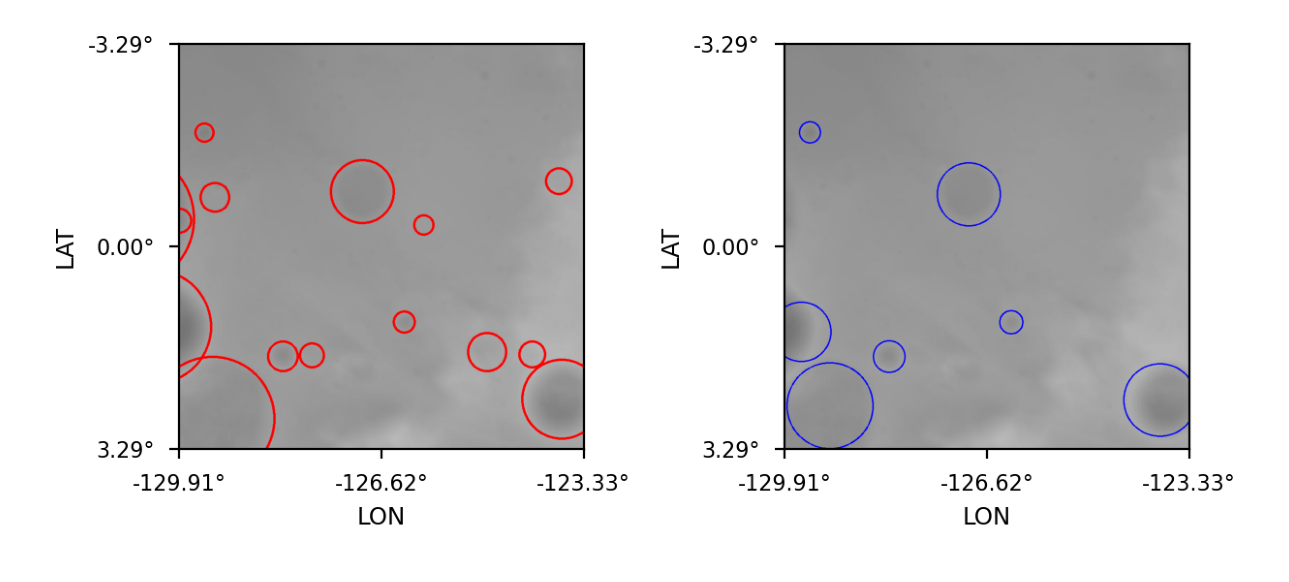

In [11]:
Img = cv2.imread('figure/Figure_1A.png')
plt.figure(dpi=250)
plt.imshow(Img)
plt.axis(False)
plt.ylim([800,250])
plt.show()

# Inner Join Merging
A questo punto viene fatto il cosidetto "inner join" merging di due dataframe: vengono cercate in pratica le triplette comuni. Essendo le misure affette da errori, ho introdotti differenti gradi di tolleranza a seconda delle invarianti geometriche. 

- tol1: esprime la tolleranza rispetto agli angoli interni.
- tol2: esprime la tolleranza rispetto ai rapporti  diametro/distanza centroide.
- tol3 & tol4: sono tolleranza rispetto alla rotazione e rapporti di grandezza relativa tra coppie di triplette.

In [12]:
tol1 = 7.

t1 = time.time()
QUERY1 = triplets_cat
QUERY2 = triplets_det
QUERY1 = dropduplicates(QUERY1)
QUERY2 = dropduplicates(QUERY2) 

if QUERY1.shape[0]<QUERY2.shape[0]:
    mode = 'natural'
    joins, items = inner_join(QUERY1, QUERY2, tol1)
else:
    mode = 'inverse'
    joins, items = inner_join(QUERY2, QUERY1, tol1)
print(f'Mode:{ mode}')
t2 = time.time()
print(f'Computational time: {t2-t1:.2f} s\nPossible list Combinations: {len(items)}')

Mode:inverse
Computational time: 0.51 s
Possible list Combinations: 35


In [13]:
t1 = time.time()
tol2 = 1.
S, iss = [], []
for i in range(len(joins)):
    join = joins[i]
    des1, des2, des3 = items[i].des1, items[i].des2, items[i].des3
    s=join[ (abs(join.des1 - des1) < tol2) & (abs(join.des2 - des2) < tol2) & (abs(join.des3 - des3) < tol2)\
          | (abs(join.des1 - des2) < tol2) & (abs(join.des2 - des3) < tol2) & (abs(join.des3 - des1) < tol2)\
          | (abs(join.des1 - des3) < tol2) & (abs(join.des2 - des1) < tol2) & (abs(join.des3 - des2) < tol2)]

    if s.shape[0] > 0:
        S.append(s)
        iss.append(items[i])
t2 = time.time()
print(f'Computational time: {t2-t1:.2f} s\nPossible list Combinations: {len(S)}')

Computational time: 0.13 s
Possible list Combinations: 34


In [14]:
# FIND TRUE COMBINATIONS:
CAMx, CAMy = ( (lon_bounds[0] + lon_bounds[1]) / 2, (lat_bounds[0] + lat_bounds[1]) / 2) # Location Absolute

Is, Js = [], []
for I in range(len(iss)):
    row1 = iss[I]
    for J in range(S[I].shape[0]):
        if check_sol(I,J, 0.1, mode, S, iss) & check_sol2(I,J, 0.14, mode, S, iss, CAMx, CAMy): # TODO: Aggiungere checksol3: confronto crts
                Is.append(I)
                Js.append(J)
                print(I,J)
Is = np.array(Is)
Js = np.array(Js)

5 3
6 0
9 1
10 4
12 0
25 0
28 0
31 0


# Plotting delle triplette Accoppiate:
Ne riporto tre a titolo di esempio.
- Sx: quella identificata nel catalogo.
- Dx: quella sulla immagine. 

In [9]:
# PLOT PAIRS:
for index in range(len(Is)):
    I = Is[index]
    J = Js[index]
    plot_sol(I,J, mode, S, iss, lon_bounds, lat_bounds, filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


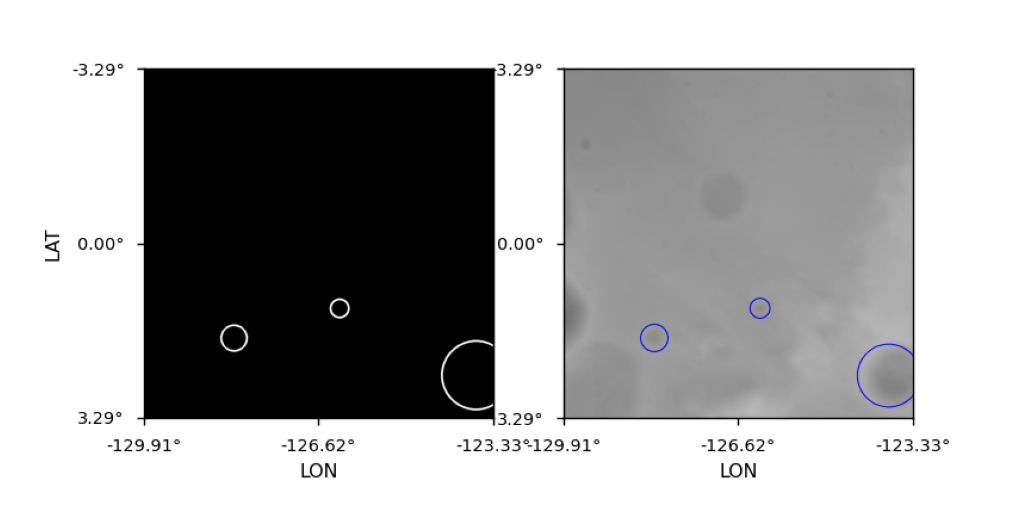

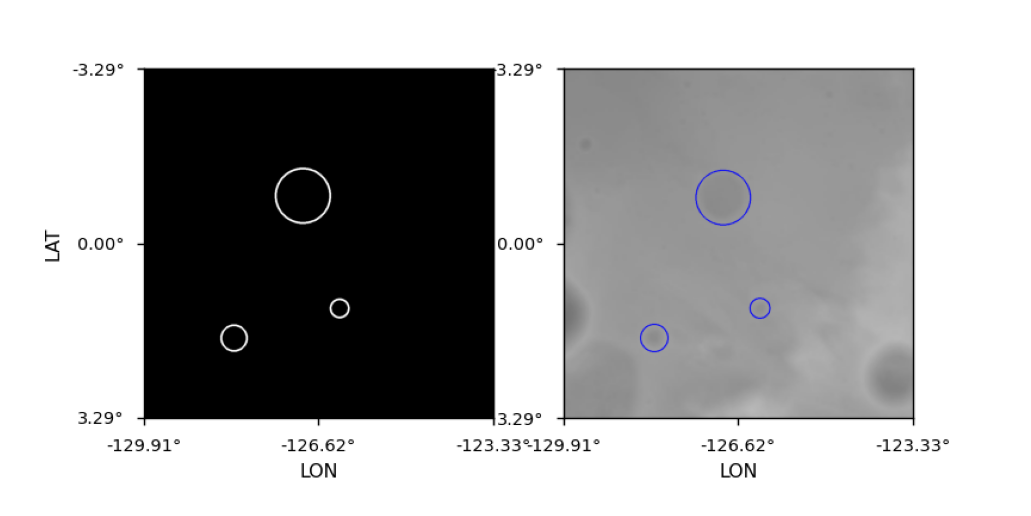

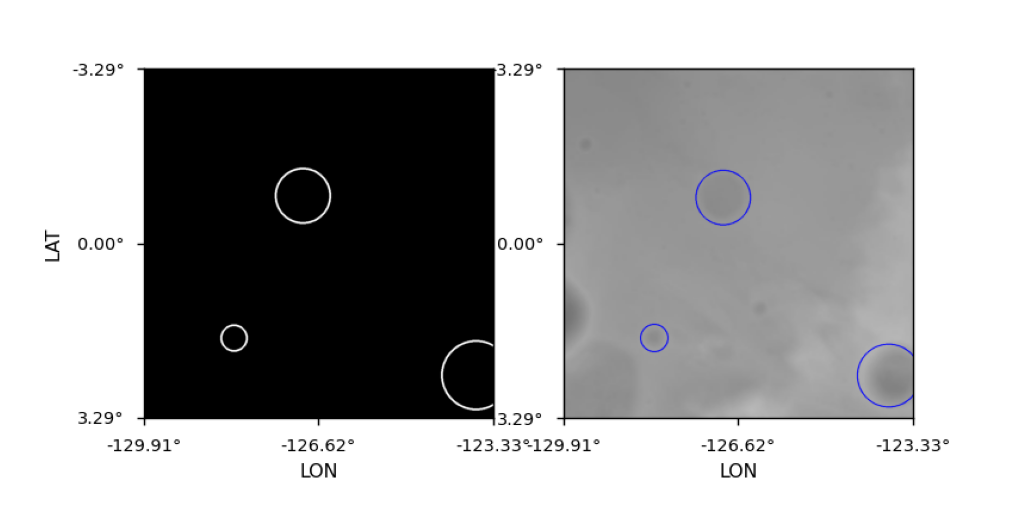

In [29]:
plt.figure(dpi=200)
img = cv2.imread(f'figure/Figure_1.png')
plt.axis(False)
plt.ylim([500,100])
plt.imshow(img)
plt.show()

plt.figure(dpi=200)
img = cv2.imread(f'figure/Figure_2.png')
plt.axis(False)
plt.ylim([500,100])
plt.imshow(img)
plt.show()

plt.figure(dpi=200)
img = cv2.imread(f'figure/Figure_3.png')
plt.axis(False)
plt.ylim([500,100])
plt.imshow(img)
plt.show()

# Stima della Posizione.
Avendo a questo punto individuato un set di triplette a le corrispondenti longitudini latitudini, non è stato difficile scrivere una formulazione che permette il calcolo dell'Altezza e Latitudine, Longitudine. La formulazione che ho utilizzato è di tipo lineare, ho semplicemente fatto corrispondere a tot numero di pixel con tot gradi di LAT/LON (le distanze tra crateri). Nota questa relazione da pixel a gradi (px2deg) e noto il numero di pixel del sensore è facile stimare l'altitudine. In maniera simile ricavo LON e LAT relaziondole al centro della immagine.

- Ultima nota: ho filtrato gli outlier con metodo dell'interquantile dal 45 al 55, di modo che le associazioni sbagliate (che a volte sono presenti per il fatto che le misure non sono comunque affette da errori) vengano non considerate ai fini di calcolo di ALT,LON,LAT.

In [30]:
if len(Js)!=0:    
    
    H, px2deg = H_estimation(Is, Js, mode, S, iss, CAMx, CAMy)
    print(f'Height: {H:.2f}          px2deg: {px2deg:.5f}')

else: print('Association was not possible...')

Height: 51.79          px2deg: 0.00402


In [31]:
if len(Js)!=0: 
    LON, LAT = [], []
    for s in range(len(Is)):
        i, j = Is[s], Js[s]
        A,B,B_a = find_ABBa(i,j,mode, S, iss, CAMx, CAMy)

        Lon, Lat = LL_estimation(A, B, B_a, px2deg)
        LON.append(Lon)
        LAT.append(Lat)
    if len(LON)>3:
        LON_m = np.mean(filter_quartile(LON))
        LAT_m = np.mean(filter_quartile(LAT))
    else:
        LON_m = np.mean(LON)
        LAT_m = np.mean(LAT)

    print(f'LON: {LON_m:.3f}       LAT:{LAT_m:.3f}')
else: print('Association was not possible...')

LON: -126.623       LAT:0.003


# L'errore
Il conseguente errore sulla stima di posizione. 

In [32]:
dt = 10
df = pd.read_csv(f'DATA/ephemeris sat/inclination zero/{dt} step size.csv', header=3, sep=';') 
real_Latitudes, real_Longitudes, real_Altitudes = df['Lat (deg)'], df['Lon (deg)'], df['Alt (km)']
real_Vxs,real_Vys,real_Vzs = df['x (km/sec)'], df['y (km/sec)'],df['z (km/sec)']

real_X, real_Y, real_Z = [], [], []
for i in range(len(df)):
    altitude = real_Altitudes[i]
    latitude = real_Latitudes[i]
    longitude = real_Longitudes[i]
    x, y, z = spherical2cartesian(altitude, latitude, longitude)
    real_X.append(x)
    real_Y.append(y)
    real_Z.append(z)
real_X, real_Y, real_Z = np.array(real_X),np.array(real_Y),np.array(real_Z)


Error = []
if len(Js)!=0: 
    TRUE_POS = np.array([real_Longitudes[idx], real_Latitudes[idx]])
    # print(TRUE_POS)
    D = TRUE_POS - np.array([LON_m,LAT_m])
    ERROR_LL = D*deg2km
    Error.append(H-50)
    Error.append(ERROR_LL[0])
    Error.append(ERROR_LL[1])
    print(f'Error (km)| H: {Error[0]:.2f}Km    Lon:{Error[1]:.2f}Km    Lat:{Error[2]:.2f}Km')
else: print('Association was not possible...')

Error (km)| H: 1.79Km    Lon:-0.02Km    Lat:-0.10Km


# Valori Globali 
Ripeto questa procedura per le prime 60 immagini distanziate di 10sec su una scan area di 100kmx100km. Ottenendo i seguenti risultati.

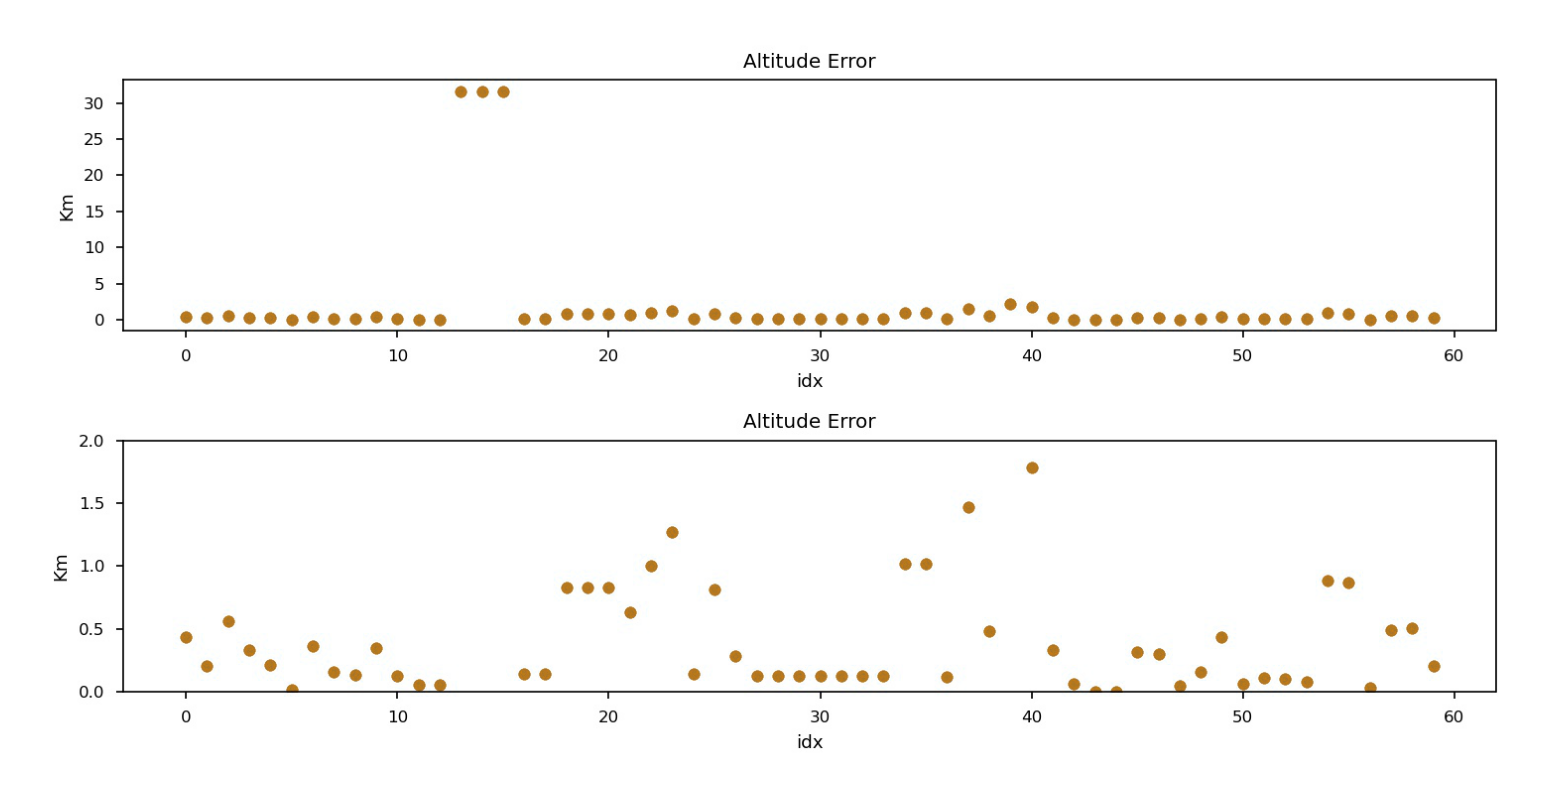

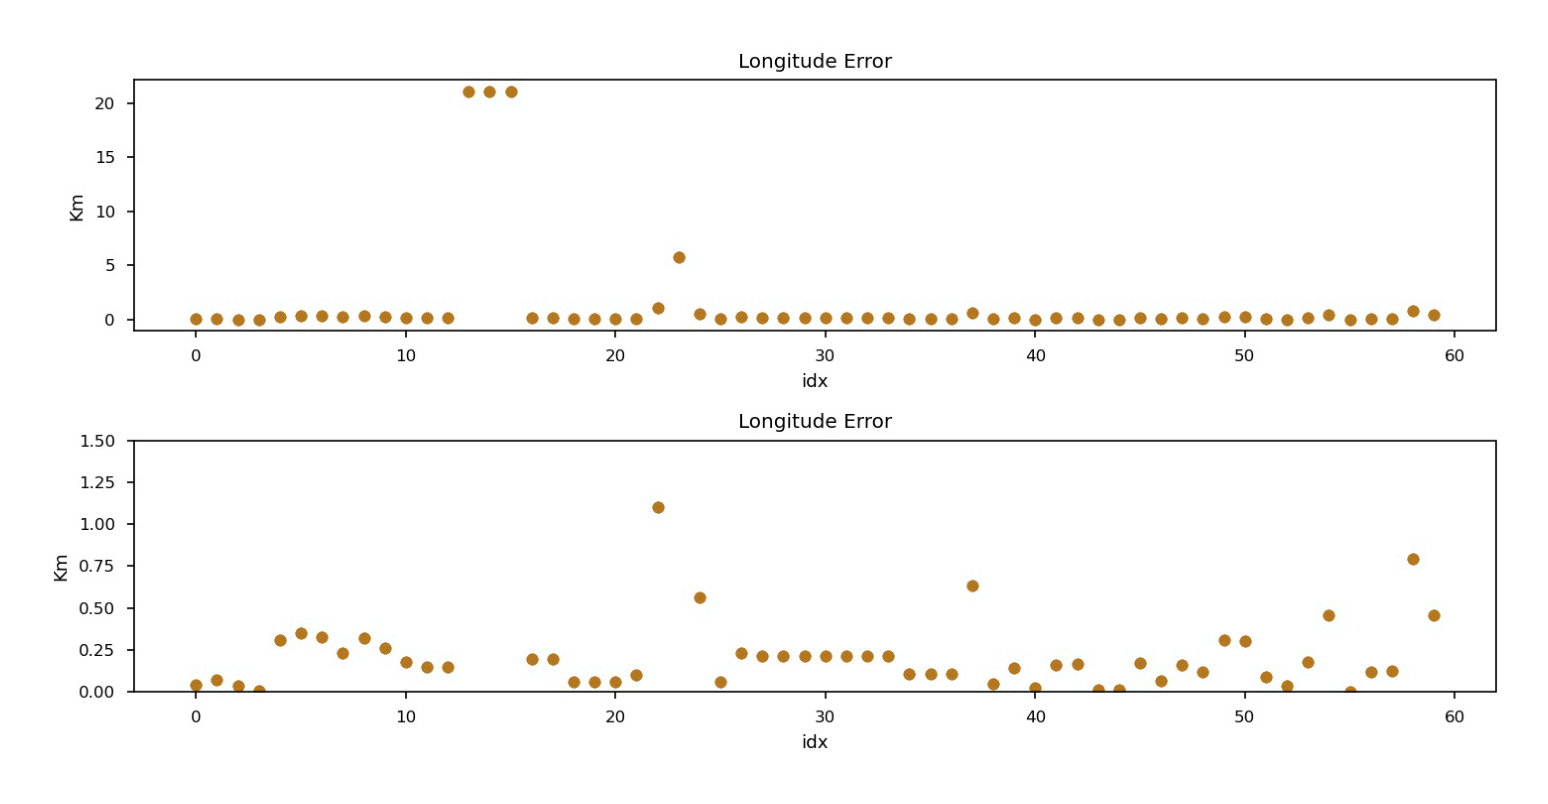

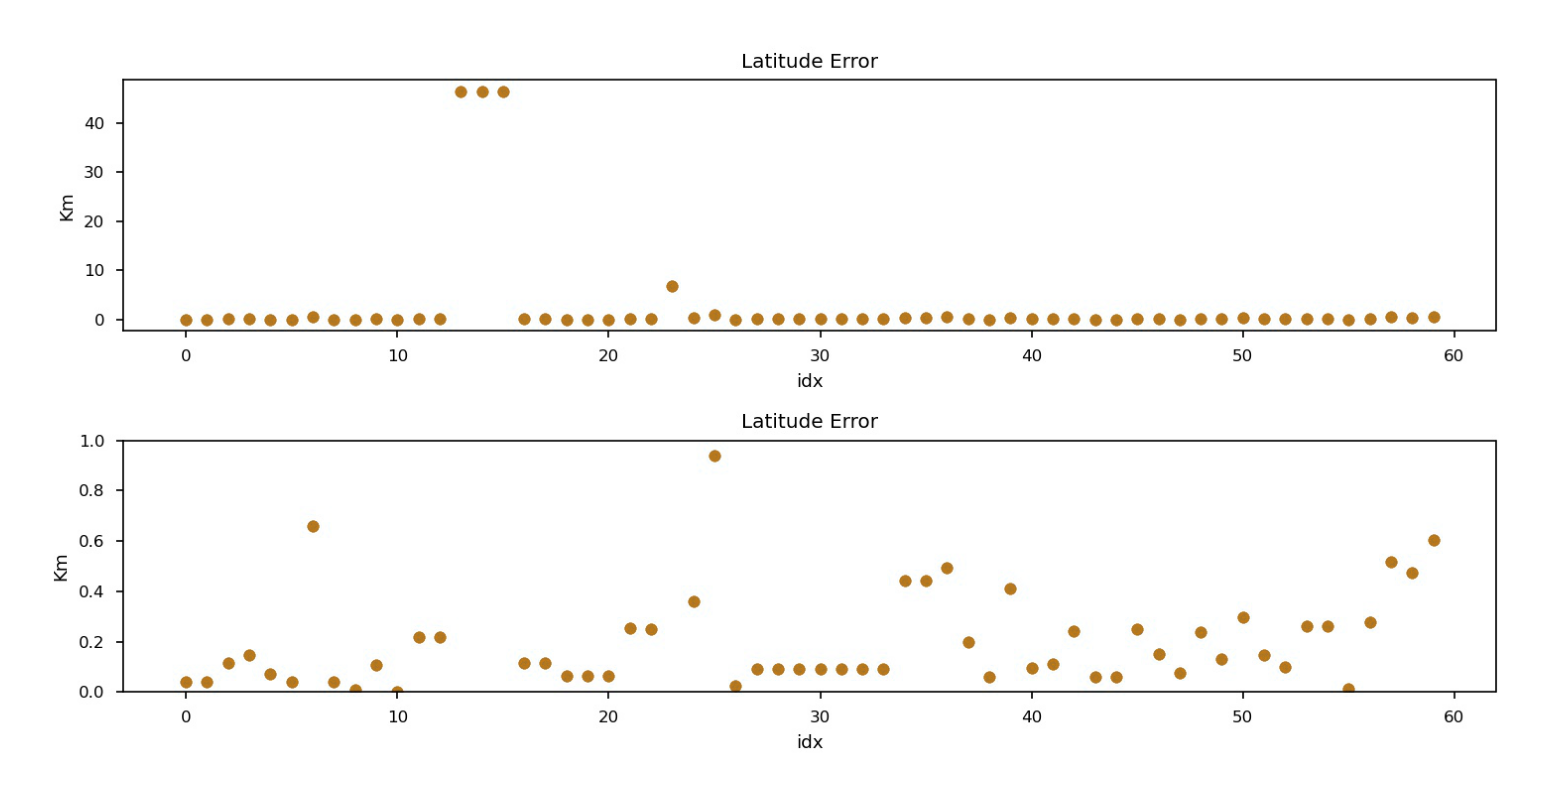

In [35]:
A = cv2.imread('AltitudeError_d=100.jpg') 
B = cv2.imread('LongitudeError_d=100.jpg') 
C = cv2.imread('LatitudeError_d=100.jpg') 
plt.figure(dpi=300)
plt.axis(False)
plt.imshow(A)
plt.figure(dpi=300)
plt.axis(False)
plt.imshow(B)
plt.figure(dpi=300)
plt.axis(False)
plt.imshow(C)
plt.show()
